# Compare celltype - consensus time group specific markers in WT ground tissue to scr and shr muatnt layers

#### Working directory should contain integrated Seurat object of WT and mutants, which is aviable on GEO under record GSE152766:

    rc.integrated_wt_shr_scr.rds
    
#### Working directory must contain subdirectories,supp_data

#### supp_data/ should contain the files, which are aviable on Github (github.com/Hsu-Che-Wei/COPILOT):

    features.tsv.gz

#### The file 'Benfey_single_cell-Samples.csv' contains the meta data of samples, which is not provided. But one can find an example of such file in Supplementary Dataset 1 (Shahan & Hsu et al.)

In [1]:
rm(list=ls())
# Set the working directory to where folders named after the samples are located. 
# The folder contains spliced.mtx, unspliced.mtx, barcodes and gene id files, and json files produced by scKB that documents the sequencing stats. 
setwd("/scratch/AG_Ohler/CheWei/scKB")

In [1]:
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(ggrepel)
library(future)
#for 300gb ram 
options(future.globals.maxSize = 300000 * 1024^2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: grid

ComplexHeatmap version 2.5.3
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps revea

In [2]:
rc.integrated <- readRDS("./rc.integrated_wt_shr_scr.rds")

In [3]:
feature_names <- read_tsv("./supp_data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()

Parsed with column specification:
cols(
  AGI = col_character(),
  Name = col_character(),
  Type = col_character()
)



In [4]:
  bscs <- read.csv("./supp_data/Benfey_single_cell-Samples.csv", na.strings=c("","NA"), stringsAsFactors = F)
  bscs <- bscs %>% select(c('sample','name','source','geno', 'genotype','transgene','treatment','age','timepoint','rep','target_cells','date','seq_run'))
  bscs$date <- gsub('^([0-9]{4})([0-9]{2})([0-9]+)$', '\\1-\\2-\\3', bscs$date)
  bscs$target_cells <- prettyNum(bscs$target_cells, big.mark = ',')

orig.idents <- data.frame(sample=rc.integrated$orig.ident)

bscs %>% filter(sample %in% orig.idents$sample)

orig.idents_info <- left_join(orig.idents, bscs, by="sample")

sample,name,source,geno,genotype,transgene,treatment,age,timepoint,rep,target_cells,date,seq_run
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>
sc_12,WT Col-0 untreated,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2019-12-20,Nolan_6131;Shahan_6158
sc_20,WT Col-0_RS1,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",NA,Shahan_6177
sc_21,WT Col-0_RS2,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",NA,Shahan_6177
sc_25,scr-4_1,Benfey lab,scr-4,scr-4 (Ws backcrossed to Col?),NA,Untreated,5_day,NA,NA,"10,000",NA,Shahan_6177
sc_30,WT Col-0_RS3,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2020-02-10,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4)
sc_31,WT Col-0_RS4,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2020-02-10,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4)
sc_36,scr_4_2,Benfey lab,scr-4,scr-4,NA,Untreated,5_day,NA,NA,"10,000",2020-02-10,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4)
sc_51,WT Col (RS_5),Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2020-02-24,Nolan_6226
sc_52,shr-2,Benfey lab,shr-2,shr-2,NA,Untreated,5_day,NA,NA,"10,000",2020-02-24,Nolan_6226


In [5]:
treatment <- orig.idents_info$treatment
names(treatment) <- colnames(rc.integrated)
head(treatment)
rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = treatment,
  col.name = 'treatment')


timepoint <- orig.idents_info$timepoint
names(timepoint) <- colnames(rc.integrated)

rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = timepoint,
  col.name = 'timepoint')



age <- orig.idents_info$age
names(age) <- colnames(rc.integrated)
rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = age,
  col.name = 'age')



rep <- orig.idents_info$rep
names(rep) <- colnames(rc.integrated)

rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = rep,
  col.name = 'rep')

date <- orig.idents_info$date
names(date) <- colnames(rc.integrated)

rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = date,
  col.name = 'date')

geno <- orig.idents_info$geno

names(geno) <- colnames(rc.integrated)

rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = geno,
  col.name = 'geno')

AAACCCAAGCCATTCA_1 AAACCCAAGCTGTTCA_1 AAACCCAAGGCGAACT_1 AAACCCACACCAGCCA_1 
       "Untreated"        "Untreated"        "Untreated"        "Untreated" 
AAACCCACACTGGCGT_1 AAACCCACAGACCTGC_1 
       "Untreated"        "Untreated"

In [6]:
rc.integrated$geno_trt <- rep("WT")
rc.integrated$geno_trt[rc.integrated$geno=="WT"] <- "WT"
rc.integrated$geno_trt[rc.integrated$geno=="shr-2"] <- "shr"
rc.integrated$geno_trt[rc.integrated$geno=="scr-4"] <- "scr"
rc.integrated$geno_trt <- factor(rc.integrated$geno_trt, levels=c("WT", "shr", "scr"))

In [7]:
# combine QC and SCN as both are based on QC markers
rc.integrated$celltype.anno <- gsub("Stem Cell Niche", "Quiescent Center", rc.integrated$celltype.anno, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

order <- c("Quiescent Center", "Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Pericycle", "Phloem", "Xylem", "Procambium", "Unknown")
palette <- c("#BD53FF", "#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#FF9900","#E6194B", "#9A6324", "#FFE119","#EEEEEE")
rc.integrated$celltype.anno <- factor(rc.integrated$celltype.anno, levels = order[sort(match(unique(rc.integrated$celltype.anno),order))])
color <- palette[sort(match(unique(rc.integrated$celltype.anno),order))]


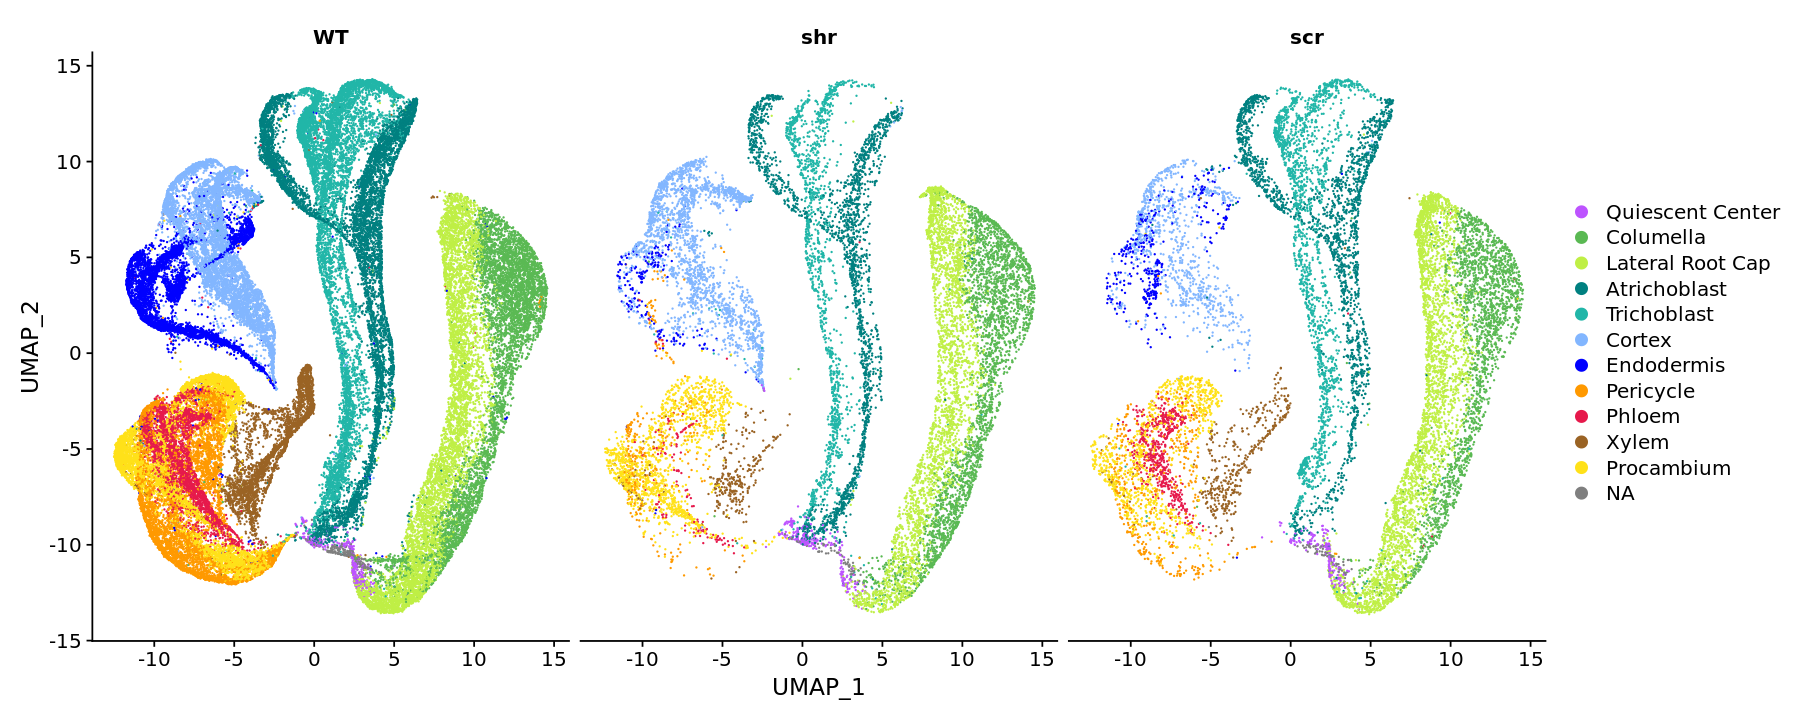

In [8]:
options(repr.plot.width=15, repr.plot.height=6)
DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno", cols=color, split.by = "geno_trt")

In [9]:
# from WT endo/cortex enrichment and heatmap
(genes_to_plt_endo <- read.csv("./supp_data/consensus_time_endo_to_plot.csv"))

genes_to_plt_endo <- genes_to_plt_endo$x

x
<chr>
AT5G06200
AT4G02090
AT3G11550
AT2G39430
AT5G65020
AT1G44970
AT2G28671
AT2G27370
AT1G80640


In [10]:
# subset for endodermis
Endo_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Stem Cell Niche", "Endodermis") & geno_trt=="WT")

In [11]:
# pseudobulk of each stage of endodermis


  afm <- as.matrix(Endo_QC@assays$SCT@data)
  pooled_endo <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(Endo_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(Endo_QC@meta.data$consensus.time.group==i)]
    pooled_endo <- cbind(pooled_endo, rowSums(m)/ncol(m))
  }



In [12]:
colnames(pooled_endo) <- unique(Endo_QC@meta.data$consensus.time.group)

In [13]:
(endo_sub_m <- pooled_endo[genes_to_plt_endo, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])
WT_endo <- endo_sub_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
AT5G06200,0.055809448,0.065548737,0.01974048,0.01376551,0.02235920,0.100691655,0.110051021,0.341690659,1.382653094,2.49216157
AT4G02090,0.046475733,0.061362096,0.03856587,0.02182088,0.01923326,0.052785414,0.056090600,0.174790404,1.338573697,2.00728469
AT3G11550,0.092857211,0.081931143,0.05974242,0.03396342,0.05185456,0.092937954,0.102873243,0.381924423,2.330190169,2.97330151
AT2G39430,0.062024550,0.076469657,0.04622624,0.03578851,0.03538263,0.104749037,0.146714752,0.542476769,1.985420345,3.05308997
AT5G65020,1.142476987,1.160562817,1.37356948,1.24891028,1.32847055,1.379982369,1.822945003,1.968845368,2.510120916,2.22642536
AT1G44970,0.034977383,0.063061082,0.03191492,0.02307658,0.02387910,0.110284445,0.121570543,0.300922168,1.074853540,1.77662335
AT2G28671,0.017591581,0.042193412,0.01402449,0.01125411,0.03293807,0.065526594,0.109415231,0.196931606,0.602373212,0.55839168
AT2G27370,0.055254915,0.099575692,0.07843054,0.05903024,0.12843400,0.346585216,0.455981800,0.608073377,1.084304002,2.56797105
AT1G80640,0.032590821,0.044761322,0.09863392,0.11894891,0.18967035,0.299830592,0.333841254,0.355075216,0.366706830,0.52101173
AT5G44790,0.273218458,0.226949475,0.32277836,0.26131303,0.35329463,0.552312591,0.773293608,1.018183073,1.340904061,1.76386342


In [14]:
# quantile normalize

mat = endo_sub_m
mat2 = t(apply(mat, 1, function(x) {
    q10 = quantile(x, 0.1)
    q90 = quantile(x, 0.9)
    x[x < q10] = q10
    x[x > q90] = q90
    scale(x)
}))
colnames(mat2) = colnames(mat)

In [15]:
# side annotation with color to match umap

endo_sa = rowAnnotation(foo = anno_block(gp = gpar(fill = "#0000FF"),
        labels = c("Endodermis"), 
        labels_gp = gpar(col = "white", fontsize = 18)))

In [16]:
feature_names <- read_tsv("./supp_data/features.tsv.gz", col_names = c("gene", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()


Parsed with column specification:
cols(
  gene = col_character(),
  Name = col_character(),
  Type = col_character()
)



In [17]:
# genes to mark on side of heatmap

(endo_mat_for_mark <- data.frame(mat2) %>% 
 rownames_to_column("gene") %>%
 left_join(feature_names) %>% 
 mutate(index=dplyr::row_number()) %>%
select(Name, index) %>%
filter(Name %in% c("XTH16", "SCR", "MYB36", "CASP1", "CASP2", "CASP3", "CASP4")))

Joining, by = "gene"



Name,index
<chr>,<int>
CASP4,1
CASP2,3
CASP3,8
CASP1,13
MYB36,38
SCR,63
XTH16,66


In [18]:
# at - index of genes you want to mark
# labels - Names to show

endo_mark_anno = rowAnnotation(foo = anno_mark(at = endo_mat_for_mark$index, labels = endo_mat_for_mark$Name, labels_gp = gpar(col = "black", fontsize = 16)))

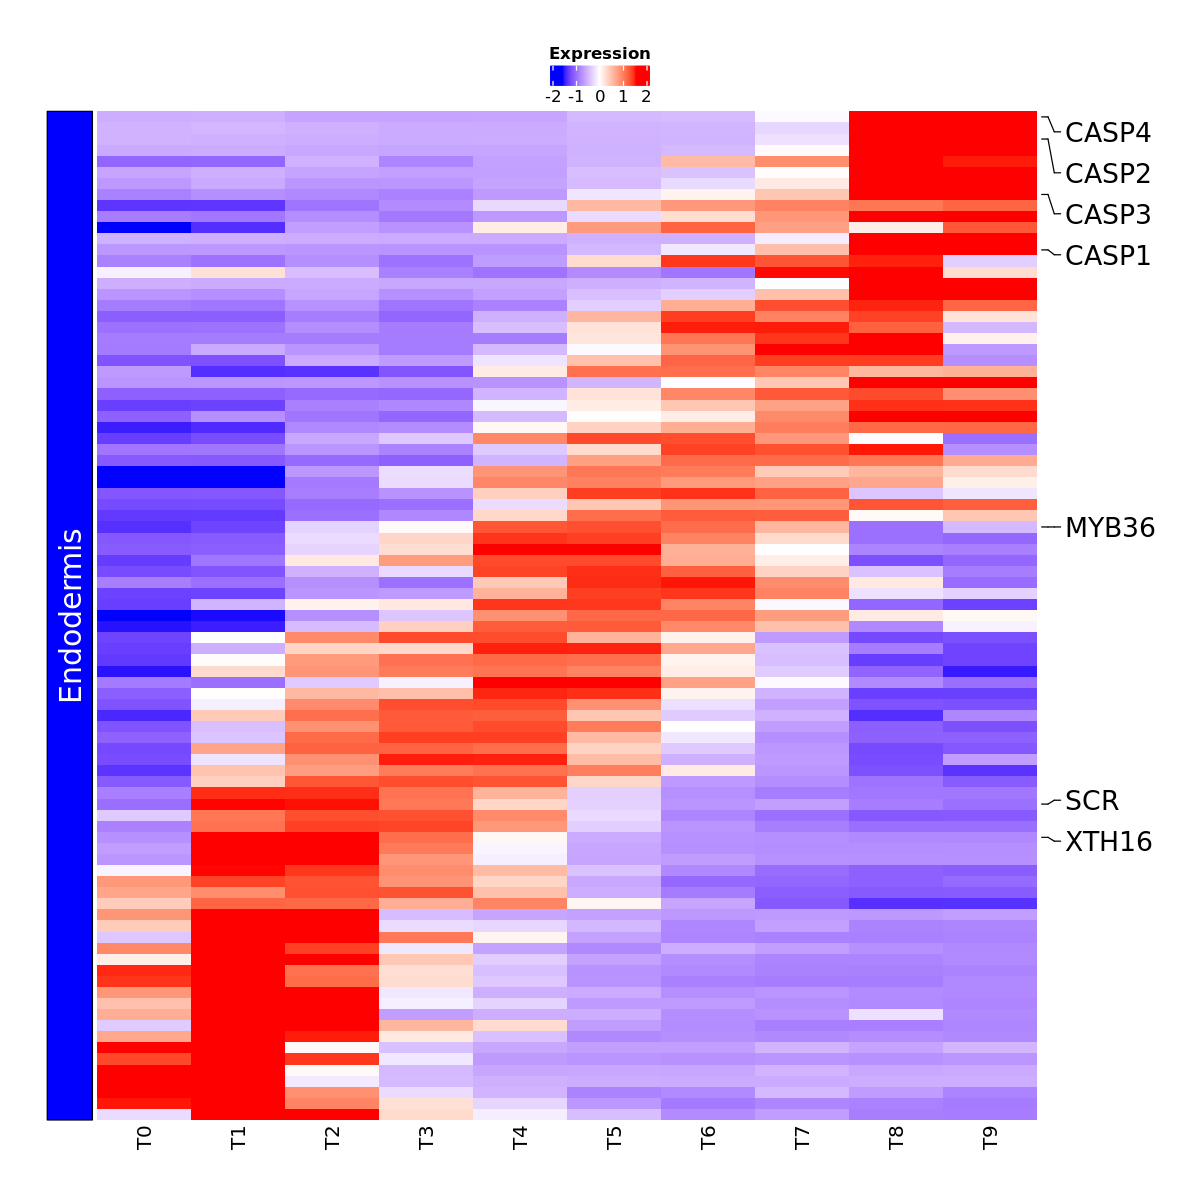

In [19]:
options(repr.plot.width=10, repr.plot.height=10)
Endo_hm <- Heatmap(mat2, 
        col = colorRamp2(c(-1.5, 0, 1.5), 
                         c('blue','white','red')), 
                show_column_names = T,
                cluster_columns = F,
        cluster_rows=F,
                show_row_names = F, 
                   left_annotation=endo_sa,
                   right_annotation=endo_mark_anno,
               heatmap_legend_param = list(title_position="topcenter", title = "Expression", direction="horizontal"))

draw(Endo_hm, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")


In [20]:
# do the same for shr and scr - matrix combined with all three before normalizing gene expression 



In [21]:
# subset for mutant layer
Endo_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Stem Cell Niche", "Endodermis", "Cortex") & geno_trt=="shr")

In [22]:
Endo_QC

An object of class Seurat 
160595 features across 2723 samples within 7 assays 
Active assay: integrated (17978 features, 17978 variable features)
 6 other assays present: RNA, SCT, spliced_RNA, unspliced_RNA, spliced_SCT, unspliced_SCT
 5 dimensional reductions calculated: pca, umap, umap_50, umap_3D, umap_2D

In [23]:
table(Endo_QC$consensus.time.group)


 T0  T1  T2  T3  T4  T5  T6  T7  T8  T9 
261  82 246 201 177 222 249 479 652 154 

In [24]:
# pseudobulk of each stage of endodermis


  afm <- as.matrix(Endo_QC@assays$SCT@data)
  pooled_endo <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(Endo_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(Endo_QC@meta.data$consensus.time.group==i)]
    pooled_endo <- cbind(pooled_endo, rowSums(m)/ncol(m))
  }



In [25]:
colnames(pooled_endo) <- unique(Endo_QC@meta.data$consensus.time.group)

In [26]:
(endo_sub_m <- pooled_endo[genes_to_plt_endo, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])

colnames(endo_sub_m) <- c("shr_T0", "shr_T1", "shr_T2", "shr_T3", "shr_T4", "shr_T5", "shr_T6", "shr_T7", "shr_T8", "shr_T9")
shr_endo_m <- endo_sub_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
AT5G06200,0.005311473,0.008453014,0.000000000,0.000000000,0.000000000,0.003122285,0.002783724,0.009250139,0.005110743,0.016135757
AT4G02090,0.029213100,0.025359043,0.019723700,0.006896987,0.011748257,0.015611423,0.008351171,0.010975982,0.007784009,0.004500956
AT3G11550,0.000000000,0.008453014,0.000000000,0.003448493,0.000000000,0.000000000,0.005567447,0.009041197,0.010056409,0.009001911
AT2G39430,0.000000000,0.000000000,0.000000000,0.003448493,0.000000000,0.018733708,0.002783724,0.015639014,0.005110743,0.000000000
AT5G65020,0.894487914,0.948523842,0.964897467,0.782104626,0.703168003,0.536798463,0.453510882,0.426082472,0.526905544,0.533820875
AT1G44970,0.002655736,0.000000000,0.000000000,0.000000000,0.000000000,0.003122285,0.000000000,0.011822464,0.001063109,0.010450896
AT2G28671,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.004341214,0.003531572,0.000000000
AT2G27370,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.014335978,0.008921950,0.014951851
AT1G80640,0.053566002,0.000000000,0.022541372,0.006896987,0.017955106,0.018733708,0.008351171,0.018811928,0.015505407,0.007133846
AT5G44790,0.240127147,0.390288803,0.345579269,0.345165113,0.259498102,0.315126154,0.282320499,0.345330226,0.425334078,0.396415578


In [27]:
# subset for mutant layer
Endo_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Stem Cell Niche", "Endodermis", "Cortex") & geno_trt=="scr")

In [28]:
Endo_QC

An object of class Seurat 
160595 features across 1473 samples within 7 assays 
Active assay: integrated (17978 features, 17978 variable features)
 6 other assays present: RNA, SCT, spliced_RNA, unspliced_RNA, spliced_SCT, unspliced_SCT
 5 dimensional reductions calculated: pca, umap, umap_50, umap_3D, umap_2D

In [29]:
table(Endo_QC$consensus.time.group)


 T0  T1  T2  T3  T4  T5  T6  T7  T8  T9 
167   4  55  64  91  73 176 222 302 319 

In [30]:
# pseudobulk of each stage of endodermis


  afm <- as.matrix(Endo_QC@assays$SCT@data)
  pooled_endo <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(Endo_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(Endo_QC@meta.data$consensus.time.group==i)]
    pooled_endo <- cbind(pooled_endo, rowSums(m)/ncol(m))
  }



In [31]:
colnames(pooled_endo) <- unique(Endo_QC@meta.data$consensus.time.group)

In [32]:
(endo_sub_m <- pooled_endo[genes_to_plt_endo, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])

colnames(endo_sub_m) <- c("scr_T0", "scr_T1", "scr_T2", "scr_T3", "scr_T4", "scr_T5", "scr_T6", "scr_T7", "scr_T8", "scr_T9")
scr_endo_m <- endo_sub_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
AT5G06200,0.019953320,0.0000000,0.02926251,0.01083042,0.000000000,0.009495167,0.000000000,0.114679661,0.422727230,2.019450817
AT4G02090,0.071896082,0.0000000,0.00000000,0.02166085,0.007617002,0.000000000,0.003938336,0.009366854,0.143006156,1.262471607
AT3G11550,0.027575869,0.0000000,0.01260268,0.04965709,0.007617002,0.000000000,0.007876673,0.166254574,0.629560052,2.062861435
AT2G39430,0.030960982,0.0000000,0.01260268,0.03433163,0.012072663,0.009495167,0.007876673,0.111813009,0.487791237,2.005637077
AT5G65020,1.355683570,0.9780058,1.13047526,1.17266722,1.003146728,0.940672448,0.705271466,0.847050210,1.129162764,1.649149829
AT1G44970,0.017938517,0.0000000,0.01997477,0.01083042,0.012072663,0.000000000,0.000000000,0.100478300,0.304371706,1.215589056
AT2G28671,0.000000000,0.0000000,0.01997477,0.00000000,0.000000000,0.000000000,0.000000000,0.050670991,0.124900288,0.562644680
AT2G27370,0.009637353,0.0000000,0.02520535,0.00000000,0.000000000,0.000000000,0.006242115,0.051492259,0.200939930,1.488123951
AT1G80640,0.039783172,0.0000000,0.01260268,0.00000000,0.022851006,0.009495167,0.011815009,0.033049265,0.059502353,0.234922389
AT5G44790,0.526202572,0.5756463,0.70762555,0.59038165,0.588276868,0.484828174,0.604909651,0.623427341,1.003904790,1.620904676


In [33]:
combined_endo_m <- cbind(WT_endo, scr_endo_m, shr_endo_m)

In [34]:
combined_endo_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,⋯,shr_T0,shr_T1,shr_T2,shr_T3,shr_T4,shr_T5,shr_T6,shr_T7,shr_T8,shr_T9
AT5G06200,0.055809448,0.065548737,0.01974048,0.01376551,0.02235920,0.100691655,0.110051021,0.341690659,1.382653094,2.49216157,⋯,0.005311473,0.008453014,0.000000000,0.000000000,0.000000000,0.003122285,0.002783724,0.009250139,0.005110743,0.016135757
AT4G02090,0.046475733,0.061362096,0.03856587,0.02182088,0.01923326,0.052785414,0.056090600,0.174790404,1.338573697,2.00728469,⋯,0.029213100,0.025359043,0.019723700,0.006896987,0.011748257,0.015611423,0.008351171,0.010975982,0.007784009,0.004500956
AT3G11550,0.092857211,0.081931143,0.05974242,0.03396342,0.05185456,0.092937954,0.102873243,0.381924423,2.330190169,2.97330151,⋯,0.000000000,0.008453014,0.000000000,0.003448493,0.000000000,0.000000000,0.005567447,0.009041197,0.010056409,0.009001911
AT2G39430,0.062024550,0.076469657,0.04622624,0.03578851,0.03538263,0.104749037,0.146714752,0.542476769,1.985420345,3.05308997,⋯,0.000000000,0.000000000,0.000000000,0.003448493,0.000000000,0.018733708,0.002783724,0.015639014,0.005110743,0.000000000
AT5G65020,1.142476987,1.160562817,1.37356948,1.24891028,1.32847055,1.379982369,1.822945003,1.968845368,2.510120916,2.22642536,⋯,0.894487914,0.948523842,0.964897467,0.782104626,0.703168003,0.536798463,0.453510882,0.426082472,0.526905544,0.533820875
AT1G44970,0.034977383,0.063061082,0.03191492,0.02307658,0.02387910,0.110284445,0.121570543,0.300922168,1.074853540,1.77662335,⋯,0.002655736,0.000000000,0.000000000,0.000000000,0.000000000,0.003122285,0.000000000,0.011822464,0.001063109,0.010450896
AT2G28671,0.017591581,0.042193412,0.01402449,0.01125411,0.03293807,0.065526594,0.109415231,0.196931606,0.602373212,0.55839168,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.004341214,0.003531572,0.000000000
AT2G27370,0.055254915,0.099575692,0.07843054,0.05903024,0.12843400,0.346585216,0.455981800,0.608073377,1.084304002,2.56797105,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.014335978,0.008921950,0.014951851
AT1G80640,0.032590821,0.044761322,0.09863392,0.11894891,0.18967035,0.299830592,0.333841254,0.355075216,0.366706830,0.52101173,⋯,0.053566002,0.000000000,0.022541372,0.006896987,0.017955106,0.018733708,0.008351171,0.018811928,0.015505407,0.007133846
AT5G44790,0.273218458,0.226949475,0.32277836,0.26131303,0.35329463,0.552312591,0.773293608,1.018183073,1.340904061,1.76386342,⋯,0.240127147,0.390288803,0.345579269,0.345165113,0.259498102,0.315126154,0.282320499,0.345330226,0.425334078,0.396415578


In [35]:
# quantile normalize

mat = combined_endo_m
mat2 = t(apply(mat, 1, function(x) {
    q10 = quantile(x, 0.1)
    q90 = quantile(x, 0.9)
    x[x < q10] = q10
    x[x > q90] = q90
    scale(x)
}))
colnames(mat2) = colnames(mat)

In [36]:
# side annotation with color to match umap

endo_sa = rowAnnotation(foo = anno_block(gp = gpar(fill = "#0000FF"),
        labels = c("Endodermis"), 
        labels_gp = gpar(col = "white", fontsize = 18)))

In [37]:
# genes to mark on side of heatmap

(endo_mat_for_mark <- data.frame(mat2) %>% 
 rownames_to_column("gene") %>%
 left_join(feature_names) %>% 
 mutate(index=dplyr::row_number()) %>%
select(Name, index) %>%
filter(Name %in% c("XTH16", "SCR", "MYB36", "CASP1", "CASP2", "CASP3", "CASP4")))

Joining, by = "gene"



Name,index
<chr>,<int>
CASP4,1
CASP2,3
CASP3,8
CASP1,13
MYB36,38
SCR,63
XTH16,66


In [38]:
# at - index of genes you want to mark
# labels - Names to show

endo_mark_anno = rowAnnotation(foo = anno_mark(at = endo_mat_for_mark$index, labels = endo_mat_for_mark$Name, labels_gp = gpar(col = "black", fontsize = 16)))

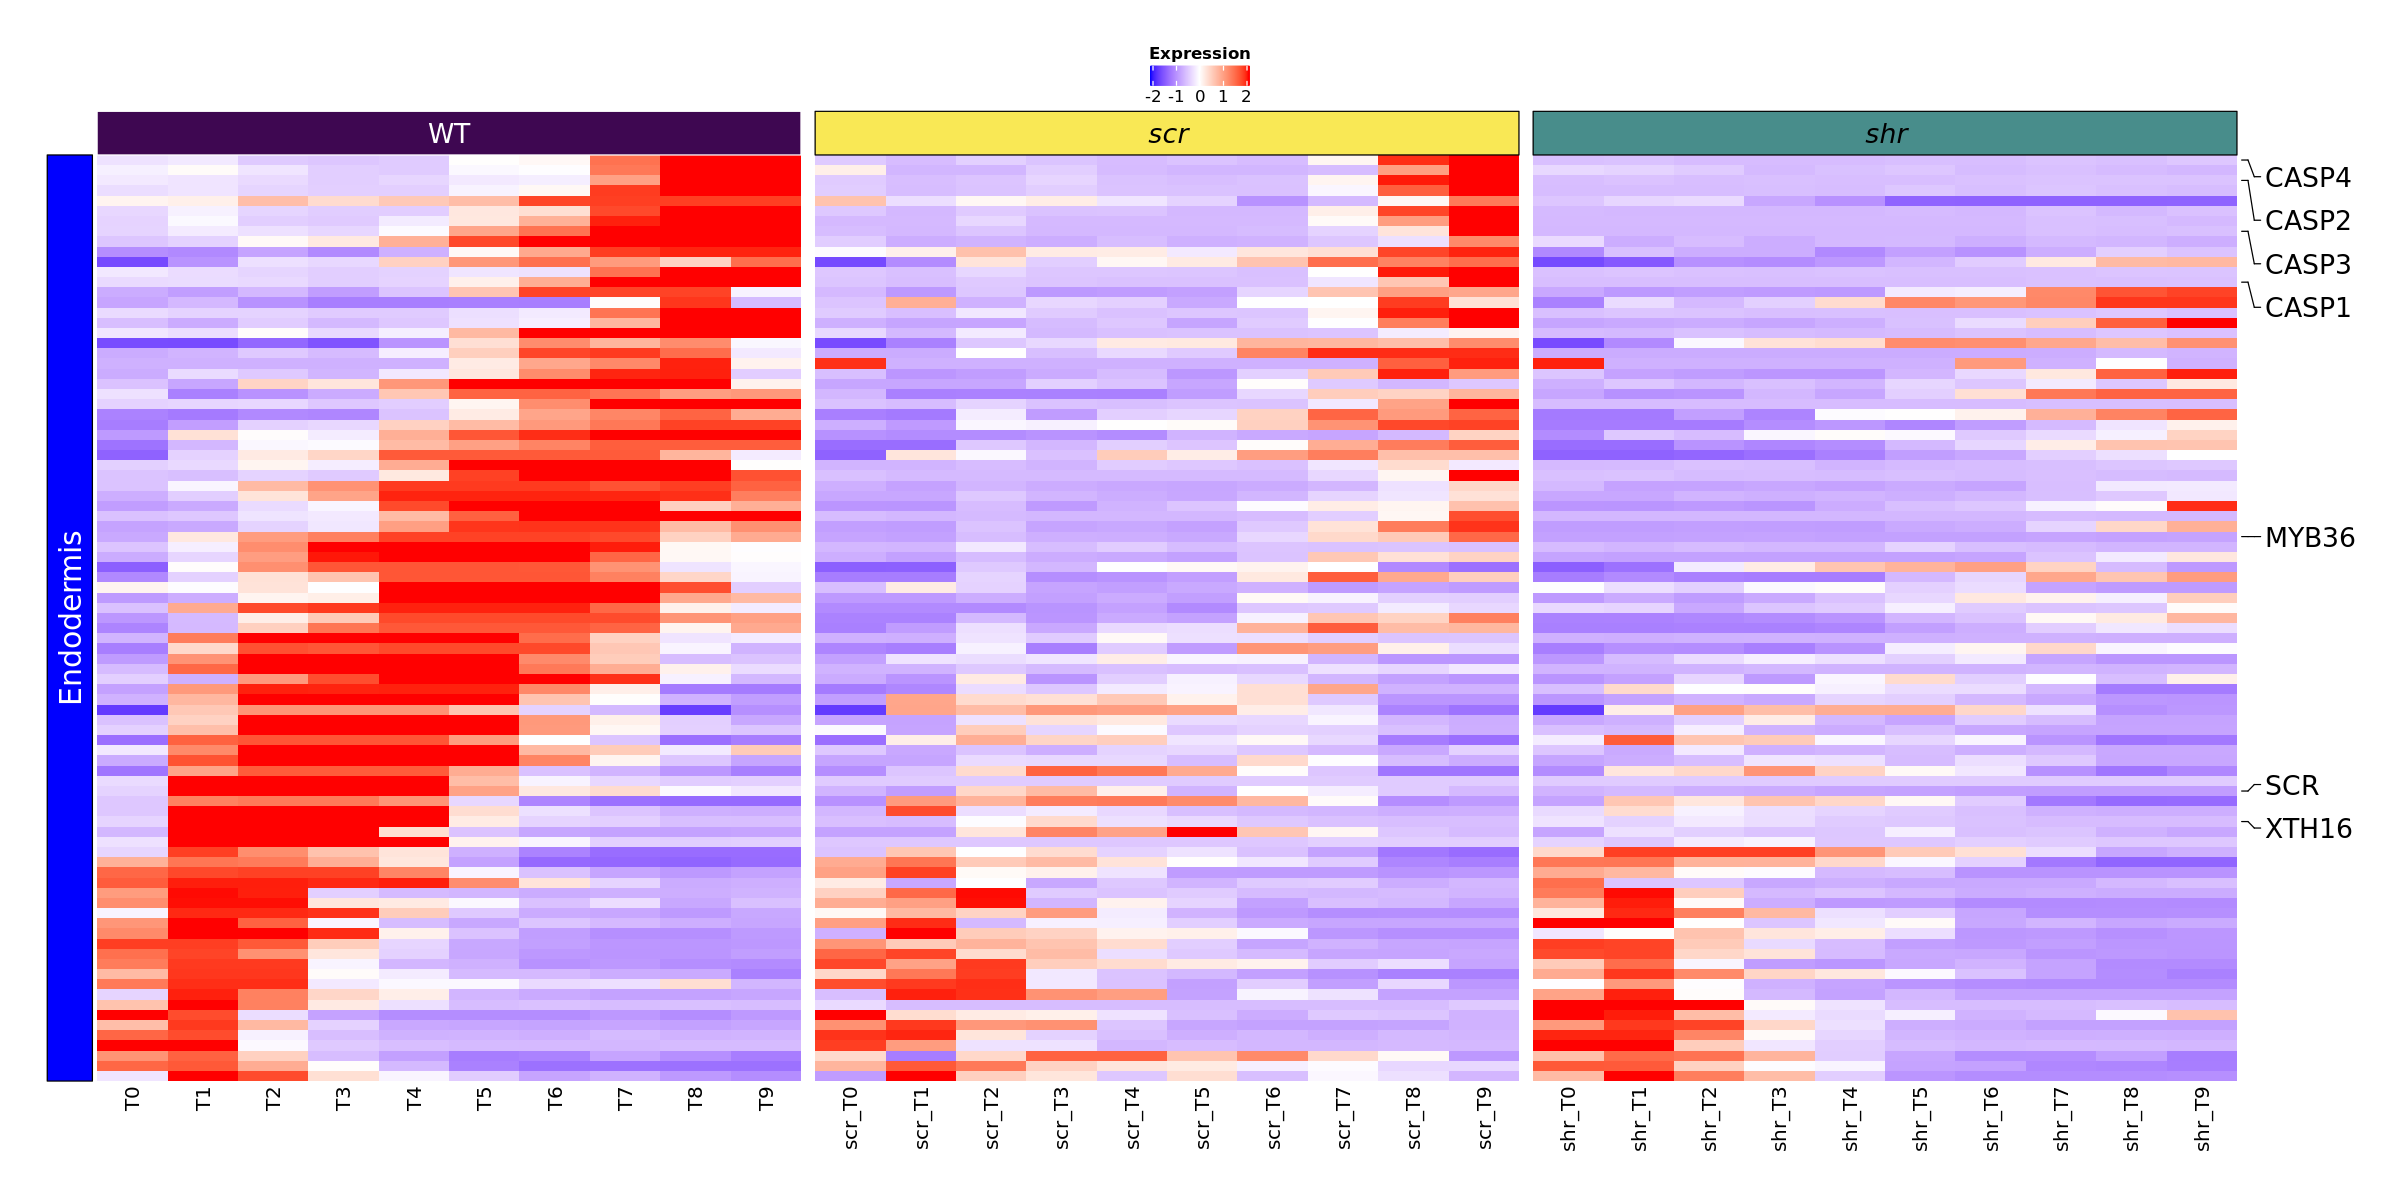

In [39]:
options(repr.plot.width=20, repr.plot.height=10)
Endo_hm <- Heatmap(mat2, 
        col = colorRamp2(c(-2, 0, 2), 
                         c('blue','white','red')), 
                show_column_names = T,
                cluster_columns = F,
        cluster_rows=F,
                show_row_names = F, 
                   left_annotation=endo_sa,
                   right_annotation=endo_mark_anno,
               heatmap_legend_param = list(title_position="topcenter", title = "Expression", direction="horizontal"), 
                                     column_split = factor(c(rep("WT", 10), rep("scr", 10), rep("shr", 10)), levels=c("WT", "scr", "shr")),  
                    cluster_column_slices = FALSE, column_title_gp = gpar(fill = c("#3E0751", "#F9E855", "#488D8B"), font = c(1,3,3), col=c("white", "black", "black"), fontsize = 16), 
                   column_gap = unit(0.3, "cm"))

draw(Endo_hm, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")


In [40]:
# cortex subset
Cor_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Stem Cell Niche", "Cortex") & geno_trt=="WT")

In [41]:
# pseudobulk of each stage of cortex


  afm <- as.matrix(Cor_QC@assays$SCT@data)
  pooled_cortex <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(Cor_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(Cor_QC@meta.data$consensus.time.group==i)]
    pooled_cortex <- cbind(pooled_cortex, rowSums(m)/ncol(m))
  }



In [42]:
colnames(pooled_cortex) <- unique(Cor_QC@meta.data$consensus.time.group)

In [43]:
genes_to_plt_cortex <- read.csv("./supp_data/consensus_time_cortex_to_plot.csv")
genes_to_plt_cortex <- genes_to_plt_cortex$x

In [44]:
(cor_sub_m <- pooled_cortex[genes_to_plt_cortex, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])

WT_cor_m <- cor_sub_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
AT3G18000,0.53075090,1.01971915,0.54413083,0.302757996,0.242222793,0.1420174612,0.078166435,0.0663041973,0.046563709,0.067641641
AT1G68560,1.12327709,0.87986124,0.46608539,0.332075464,0.340863357,0.1594135143,0.056123219,0.0567830866,0.050208087,0.046453894
AT2G24280,0.05437656,0.44997882,0.09536862,0.068951120,0.070379136,0.0306147004,0.024791523,0.0197430779,0.014724880,0.018359643
AT3G09455,0.22331777,0.74230431,0.26485138,0.141901946,0.127091226,0.0634599000,0.030454473,0.0372117974,0.040962683,0.024297293
AT3G52960,0.66393986,1.26932445,0.44753655,0.286582741,0.211506144,0.1319507761,0.076835320,0.0713831233,0.078864267,0.059157327
AT3G54960,0.41333366,0.64021723,0.58961865,0.538191460,0.502030096,0.3423626461,0.184933799,0.1797914728,0.126022911,0.114155175
AT2G34020,0.34256406,0.55649960,0.21636806,0.099327400,0.072675346,0.0331573668,0.013920970,0.0081193975,0.009002303,0.005453224
AT2G20515,0.72612350,1.02789565,0.33443651,0.112441665,0.055434516,0.0206189135,0.001786462,0.0102219673,0.012282028,0.004968797
AT2G45050,0.63283397,1.23432099,0.57371837,0.234428887,0.155491128,0.0414490188,0.027622998,0.0378217982,0.028086884,0.016562657
AT5G05890,0.18180540,0.43332991,0.20200205,0.115537407,0.102696383,0.0465328490,0.013027739,0.0077094226,0.001430644,0.008765755


In [45]:
# annotation bar for consensus time
library(RColorBrewer)
col_fun <- brewer.pal(10,"Spectral")

names(col_fun) <- c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")
col_fun

ha = HeatmapAnnotation(`Consensus Time Group` = c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"), col = list(`Consensus Time Group` = col_fun), show_legend = F)

T0        T1        T2        T3        T4        T5        T6        T7 
"#9E0142" "#D53E4F" "#F46D43" "#FDAE61" "#FEE08B" "#E6F598" "#ABDDA4" "#66C2A5" 
       T8        T9 
"#3288BD" "#5E4FA2"

In [46]:
# quantile normalize

mat = cor_sub_m
mat2 = t(apply(mat, 1, function(x) {
    q10 = quantile(x, 0.1)
    q90 = quantile(x, 0.9)
    x[x < q10] = q10
    x[x > q90] = q90
    scale(x)
}))
colnames(mat2) = colnames(mat)

In [47]:
# side annotation to match cortex colors

cortex_sa = rowAnnotation(foo = anno_block(gp = gpar(fill = "#82B6FF"),
        labels = c("Cortex"), 
        labels_gp = gpar(col = "black", fontsize = 18)))

In [48]:
# genes to label on side of heatmap for cortex

(cor_mat_for_mark <- data.frame(mat2) %>% 
 rownames_to_column("gene") %>%
 left_join(feature_names) %>% 
 mutate(index=dplyr::row_number()) %>%
select(Name, index) %>%
filter(Name %in% c("AT1G17285", "AT5G02000", "C/VIF2", "CYP72A15", "PER56", "PER69", "AT4G09760")))

Joining, by = "gene"



Name,index
<chr>,<int>
AT1G17285,18
AT5G02000,27
C/VIF2,60
CYP72A15,66
PER56,74
PER69,75
AT4G09760,80


In [49]:
# at - index of genes you want to mark
# labels - Names to show

cor_mark_anno = rowAnnotation(foo = anno_mark(at = cor_mat_for_mark$index, labels = cor_mat_for_mark$Name, labels_gp = gpar(col = "black", fontsize = 16)))

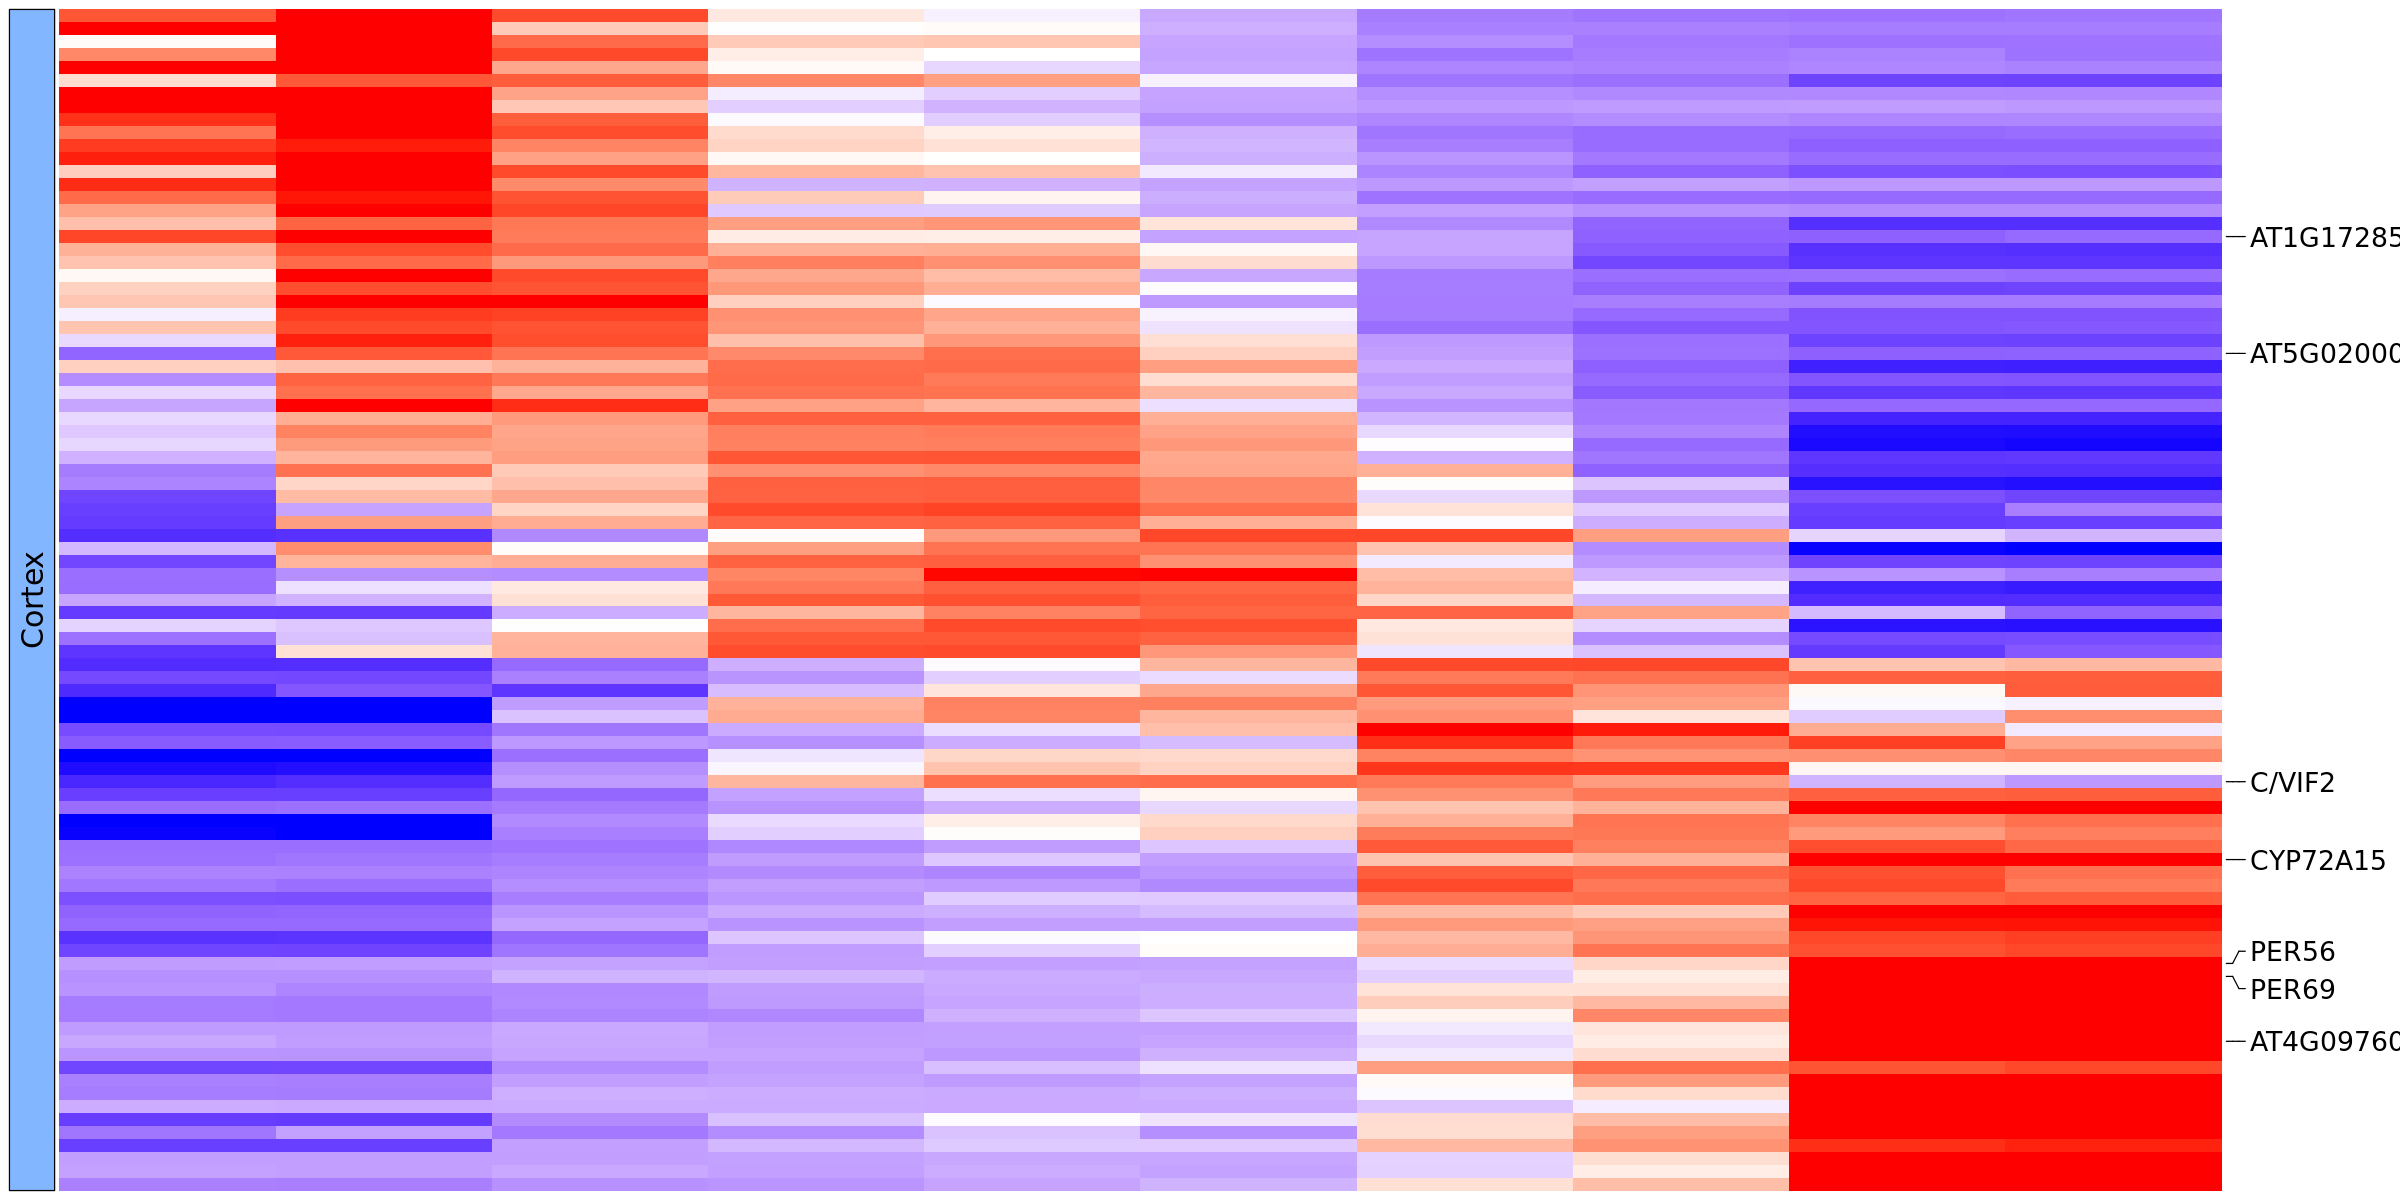

In [50]:
# ['#d8b365','#f5f5f5','#5ab4ac']

Cortex_hm <- Heatmap(mat2, 
        col = colorRamp2(c(-1.5, 0, 1.5), 
                         c('blue','white','red')), 
                show_column_names = F,
                cluster_columns = F,
        cluster_rows=F,
                show_row_names = F, 
        show_heatmap_legend = F, 
        left_annotation=cortex_sa, 
        right_annotation=cor_mark_anno)

Cortex_hm



In [51]:
# text annotation for consensus time

ht = columnAnnotation(foo = anno_text(c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"), rot = 0, just = "center", gp = gpar(fontsize = 16)))

In [52]:
# subset for mutant layer
COR_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Stem Cell Niche", "Endodermis", "Cortex") & geno_trt=="shr")

In [53]:
COR_QC

An object of class Seurat 
160595 features across 2723 samples within 7 assays 
Active assay: integrated (17978 features, 17978 variable features)
 6 other assays present: RNA, SCT, spliced_RNA, unspliced_RNA, spliced_SCT, unspliced_SCT
 5 dimensional reductions calculated: pca, umap, umap_50, umap_3D, umap_2D

In [54]:
# pseudobulk of each stage of endodermis


  afm <- as.matrix(COR_QC@assays$SCT@data)
  pooled_cor <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(COR_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(COR_QC@meta.data$consensus.time.group==i)]
    pooled_cor <- cbind(pooled_cor, rowSums(m)/ncol(m))
  }



In [55]:
colnames(pooled_cor) <- unique(COR_QC@meta.data$consensus.time.group)

In [56]:
(cor_sub_m <- pooled_cor[genes_to_plt_cortex, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])

colnames(cor_sub_m) <- c("shr_T0", "shr_T1", "shr_T2", "shr_T3", "shr_T4", "shr_T5", "shr_T6", "shr_T7", "shr_T8", "shr_T9")
shr_cor_m <- cor_sub_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
AT3G18000,0.49313450,0.94612860,0.486068540,0.395587142,0.16972895,0.122064897,0.091180554,0.046443375,0.031452045,0.020636713
AT1G68560,1.08124455,0.53444732,0.297038706,0.172165388,0.08911009,0.064802666,0.013918618,0.011822464,0.017009747,0.004500956
AT2G24280,0.10663746,0.32903200,0.178475475,0.125317734,0.10314911,0.097851931,0.047323301,0.037269160,0.034200142,0.032955674
AT3G09455,0.30100508,0.39172518,0.252264224,0.258704426,0.14622606,0.089250388,0.054519123,0.027740249,0.023569051,0.029638625
AT3G52960,0.70455086,0.67992849,0.445523291,0.342899522,0.32859296,0.185041143,0.180732734,0.133870602,0.130001468,0.116686433
AT3G54960,0.41185610,0.51788484,0.489593606,0.422345230,0.25839785,0.191520469,0.119231623,0.045436223,0.046236588,0.036007646
AT2G34020,0.34424733,0.26062083,0.068102908,0.031036441,0.03916086,0.012489138,0.002783724,0.002894143,0.003189328,0.013502867
AT2G20515,0.73834723,0.56781587,0.240846632,0.085953052,0.04145162,0.009366854,0.000000000,0.004341214,0.003811207,0.000000000
AT2G45050,0.89305586,1.08275240,0.544822418,0.214077106,0.10374437,0.025983428,0.016702342,0.002894143,0.011874850,0.004500956
AT5G05890,0.21090972,0.42760918,0.303148254,0.336267434,0.20238214,0.147808484,0.068437741,0.025692589,0.010189862,0.009001911


In [57]:
# subset for mutant layer
COR_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Stem Cell Niche", "Endodermis", "Cortex") & geno_trt=="scr")

In [58]:
COR_QC

An object of class Seurat 
160595 features across 1473 samples within 7 assays 
Active assay: integrated (17978 features, 17978 variable features)
 6 other assays present: RNA, SCT, spliced_RNA, unspliced_RNA, spliced_SCT, unspliced_SCT
 5 dimensional reductions calculated: pca, umap, umap_50, umap_3D, umap_2D

In [59]:
# pseudobulk of each stage of endodermis


  afm <- as.matrix(COR_QC@assays$SCT@data)
  pooled_cor <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(COR_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(COR_QC@meta.data$consensus.time.group==i)]
    pooled_cor <- cbind(pooled_cor, rowSums(m)/ncol(m))
  }



In [60]:
colnames(pooled_cor) <- unique(COR_QC@meta.data$consensus.time.group)

In [61]:
(cor_sub_m <- pooled_cor[genes_to_plt_cortex, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])

colnames(cor_sub_m) <- c("scr_T0", "scr_T1", "scr_T2", "scr_T3", "scr_T4", "scr_T5", "scr_T6", "scr_T7", "scr_T8", "scr_T9")
scr_cor_m <- cor_sub_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
AT3G18000,0.330581865,0.2746531,0.44914750,0.52451876,0.38144761,0.225231737,0.143787770,0.135559186,0.065997911,0.101429161
AT1G68560,1.141139220,0.6212267,0.24653660,0.27178666,0.08824268,0.115555469,0.043990921,0.059853962,0.039798239,0.048172480
AT2G24280,0.035632590,0.1732868,0.24564951,0.28426335,0.12948903,0.085456502,0.131303540,0.089250388,0.052226775,0.039111753
AT3G09455,0.221784633,0.4479399,0.19332316,0.19494764,0.10031534,0.056971001,0.020360903,0.026804696,0.028322292,0.041653854
AT3G52960,0.506926498,0.8958797,0.62706525,0.44425915,0.40358940,0.391814856,0.319751453,0.340155305,0.278318085,0.279367206
AT3G54960,0.724887504,0.1732868,0.65987271,0.80941638,0.68917732,0.402039400,0.205765233,0.218514131,0.216752732,0.198605136
AT2G34020,0.362904418,0.3465736,0.06301338,0.05599248,0.01968966,0.009495167,0.006242115,0.009366854,0.010523357,0.000000000
AT2G20515,0.509816646,0.3465736,0.07775757,0.07765333,0.00000000,0.009495167,0.000000000,0.000000000,0.004590379,0.002172875
AT2G45050,0.717389793,1.2982392,0.27794062,0.09297879,0.05015767,0.009495167,0.029872133,0.009366854,0.032912671,0.025172677
AT5G05890,0.107603058,0.4479399,0.22898968,0.19862836,0.12762201,0.119496319,0.043321699,0.020560127,0.004590379,0.002172875


In [62]:
combined_cor_m <- cbind(WT_cor_m, scr_cor_m, shr_cor_m)

In [63]:
combined_cor_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,⋯,shr_T0,shr_T1,shr_T2,shr_T3,shr_T4,shr_T5,shr_T6,shr_T7,shr_T8,shr_T9
AT3G18000,0.53075090,1.01971915,0.54413083,0.302757996,0.242222793,0.1420174612,0.078166435,0.0663041973,0.046563709,0.067641641,⋯,0.49313450,0.94612860,0.486068540,0.395587142,0.16972895,0.122064897,0.091180554,0.046443375,0.031452045,0.020636713
AT1G68560,1.12327709,0.87986124,0.46608539,0.332075464,0.340863357,0.1594135143,0.056123219,0.0567830866,0.050208087,0.046453894,⋯,1.08124455,0.53444732,0.297038706,0.172165388,0.08911009,0.064802666,0.013918618,0.011822464,0.017009747,0.004500956
AT2G24280,0.05437656,0.44997882,0.09536862,0.068951120,0.070379136,0.0306147004,0.024791523,0.0197430779,0.014724880,0.018359643,⋯,0.10663746,0.32903200,0.178475475,0.125317734,0.10314911,0.097851931,0.047323301,0.037269160,0.034200142,0.032955674
AT3G09455,0.22331777,0.74230431,0.26485138,0.141901946,0.127091226,0.0634599000,0.030454473,0.0372117974,0.040962683,0.024297293,⋯,0.30100508,0.39172518,0.252264224,0.258704426,0.14622606,0.089250388,0.054519123,0.027740249,0.023569051,0.029638625
AT3G52960,0.66393986,1.26932445,0.44753655,0.286582741,0.211506144,0.1319507761,0.076835320,0.0713831233,0.078864267,0.059157327,⋯,0.70455086,0.67992849,0.445523291,0.342899522,0.32859296,0.185041143,0.180732734,0.133870602,0.130001468,0.116686433
AT3G54960,0.41333366,0.64021723,0.58961865,0.538191460,0.502030096,0.3423626461,0.184933799,0.1797914728,0.126022911,0.114155175,⋯,0.41185610,0.51788484,0.489593606,0.422345230,0.25839785,0.191520469,0.119231623,0.045436223,0.046236588,0.036007646
AT2G34020,0.34256406,0.55649960,0.21636806,0.099327400,0.072675346,0.0331573668,0.013920970,0.0081193975,0.009002303,0.005453224,⋯,0.34424733,0.26062083,0.068102908,0.031036441,0.03916086,0.012489138,0.002783724,0.002894143,0.003189328,0.013502867
AT2G20515,0.72612350,1.02789565,0.33443651,0.112441665,0.055434516,0.0206189135,0.001786462,0.0102219673,0.012282028,0.004968797,⋯,0.73834723,0.56781587,0.240846632,0.085953052,0.04145162,0.009366854,0.000000000,0.004341214,0.003811207,0.000000000
AT2G45050,0.63283397,1.23432099,0.57371837,0.234428887,0.155491128,0.0414490188,0.027622998,0.0378217982,0.028086884,0.016562657,⋯,0.89305586,1.08275240,0.544822418,0.214077106,0.10374437,0.025983428,0.016702342,0.002894143,0.011874850,0.004500956
AT5G05890,0.18180540,0.43332991,0.20200205,0.115537407,0.102696383,0.0465328490,0.013027739,0.0077094226,0.001430644,0.008765755,⋯,0.21090972,0.42760918,0.303148254,0.336267434,0.20238214,0.147808484,0.068437741,0.025692589,0.010189862,0.009001911


In [64]:
# quantile normalize

mat = combined_cor_m
mat2 = t(apply(mat, 1, function(x) {
    q10 = quantile(x, 0.1)
    q90 = quantile(x, 0.9)
    x[x < q10] = q10
    x[x > q90] = q90
    scale(x)
}))
colnames(mat2) = colnames(mat)

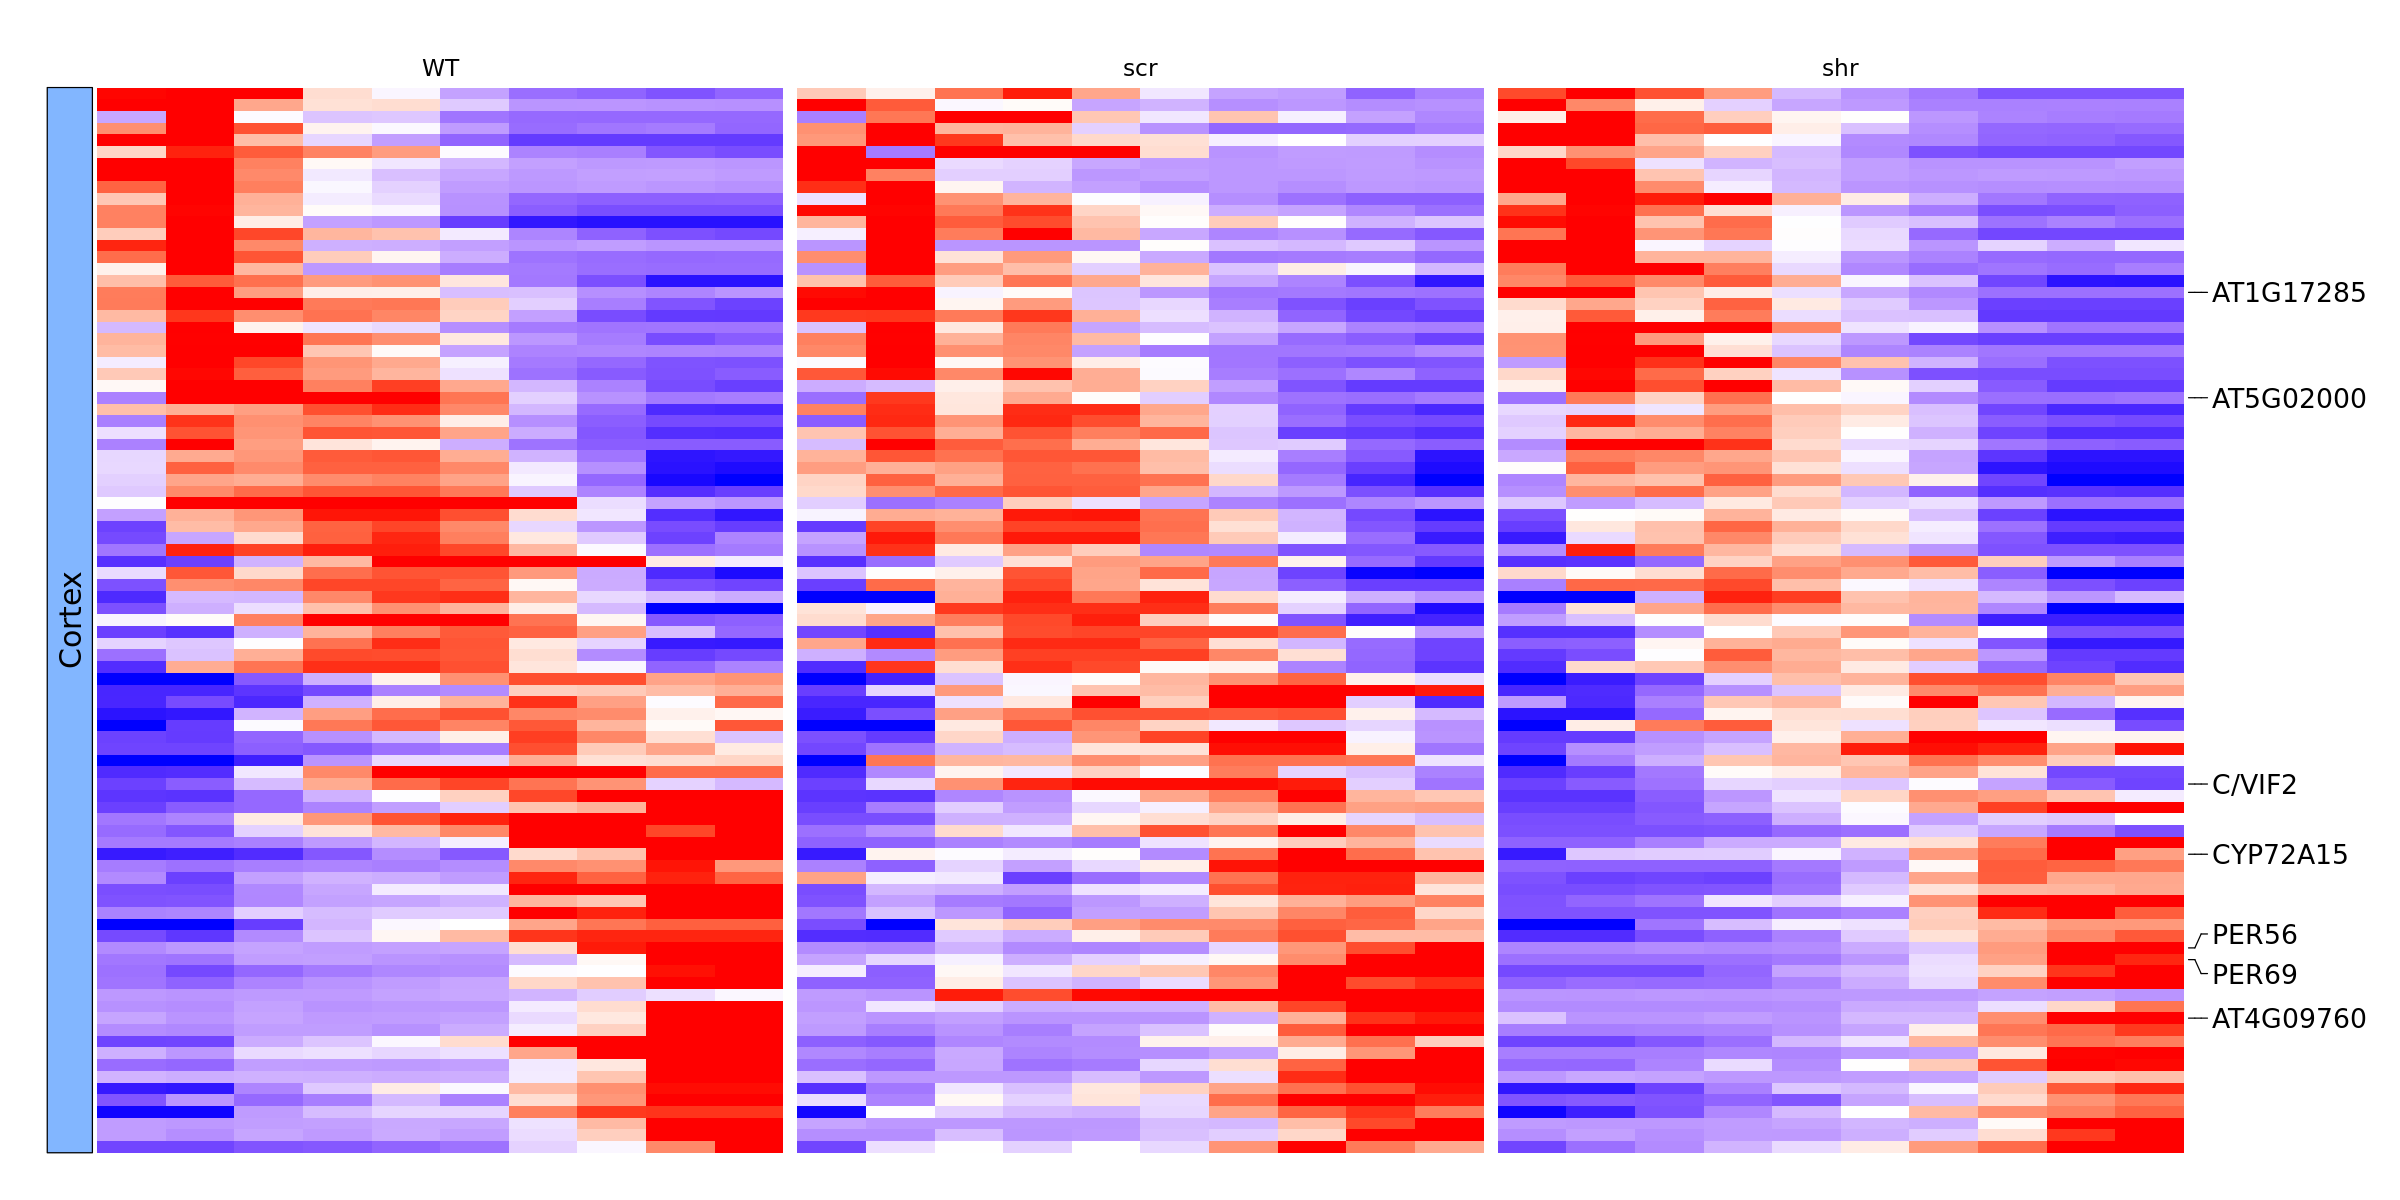

In [65]:
# ['#d8b365','#f5f5f5','#5ab4ac']

Cortex_hm <- Heatmap(mat2, 
        col = colorRamp2(c(-1.5, 0, 1.5), 
                         c('blue','white','red')), 
                show_column_names = F,
                cluster_columns = F,
        cluster_rows=F,
                show_row_names = F, 
        show_heatmap_legend = F, 
        left_annotation=cortex_sa, 
        right_annotation=cor_mark_anno, 
                    column_split = factor(c(rep("WT", 10), rep("scr", 10), rep("shr", 10)), levels=c("WT", "scr", "shr")),  
                    cluster_column_slices = FALSE, column_gap = unit(0.3, "cm"))



options(repr.plot.width=20, repr.plot.height=10)

draw(Cortex_hm, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")


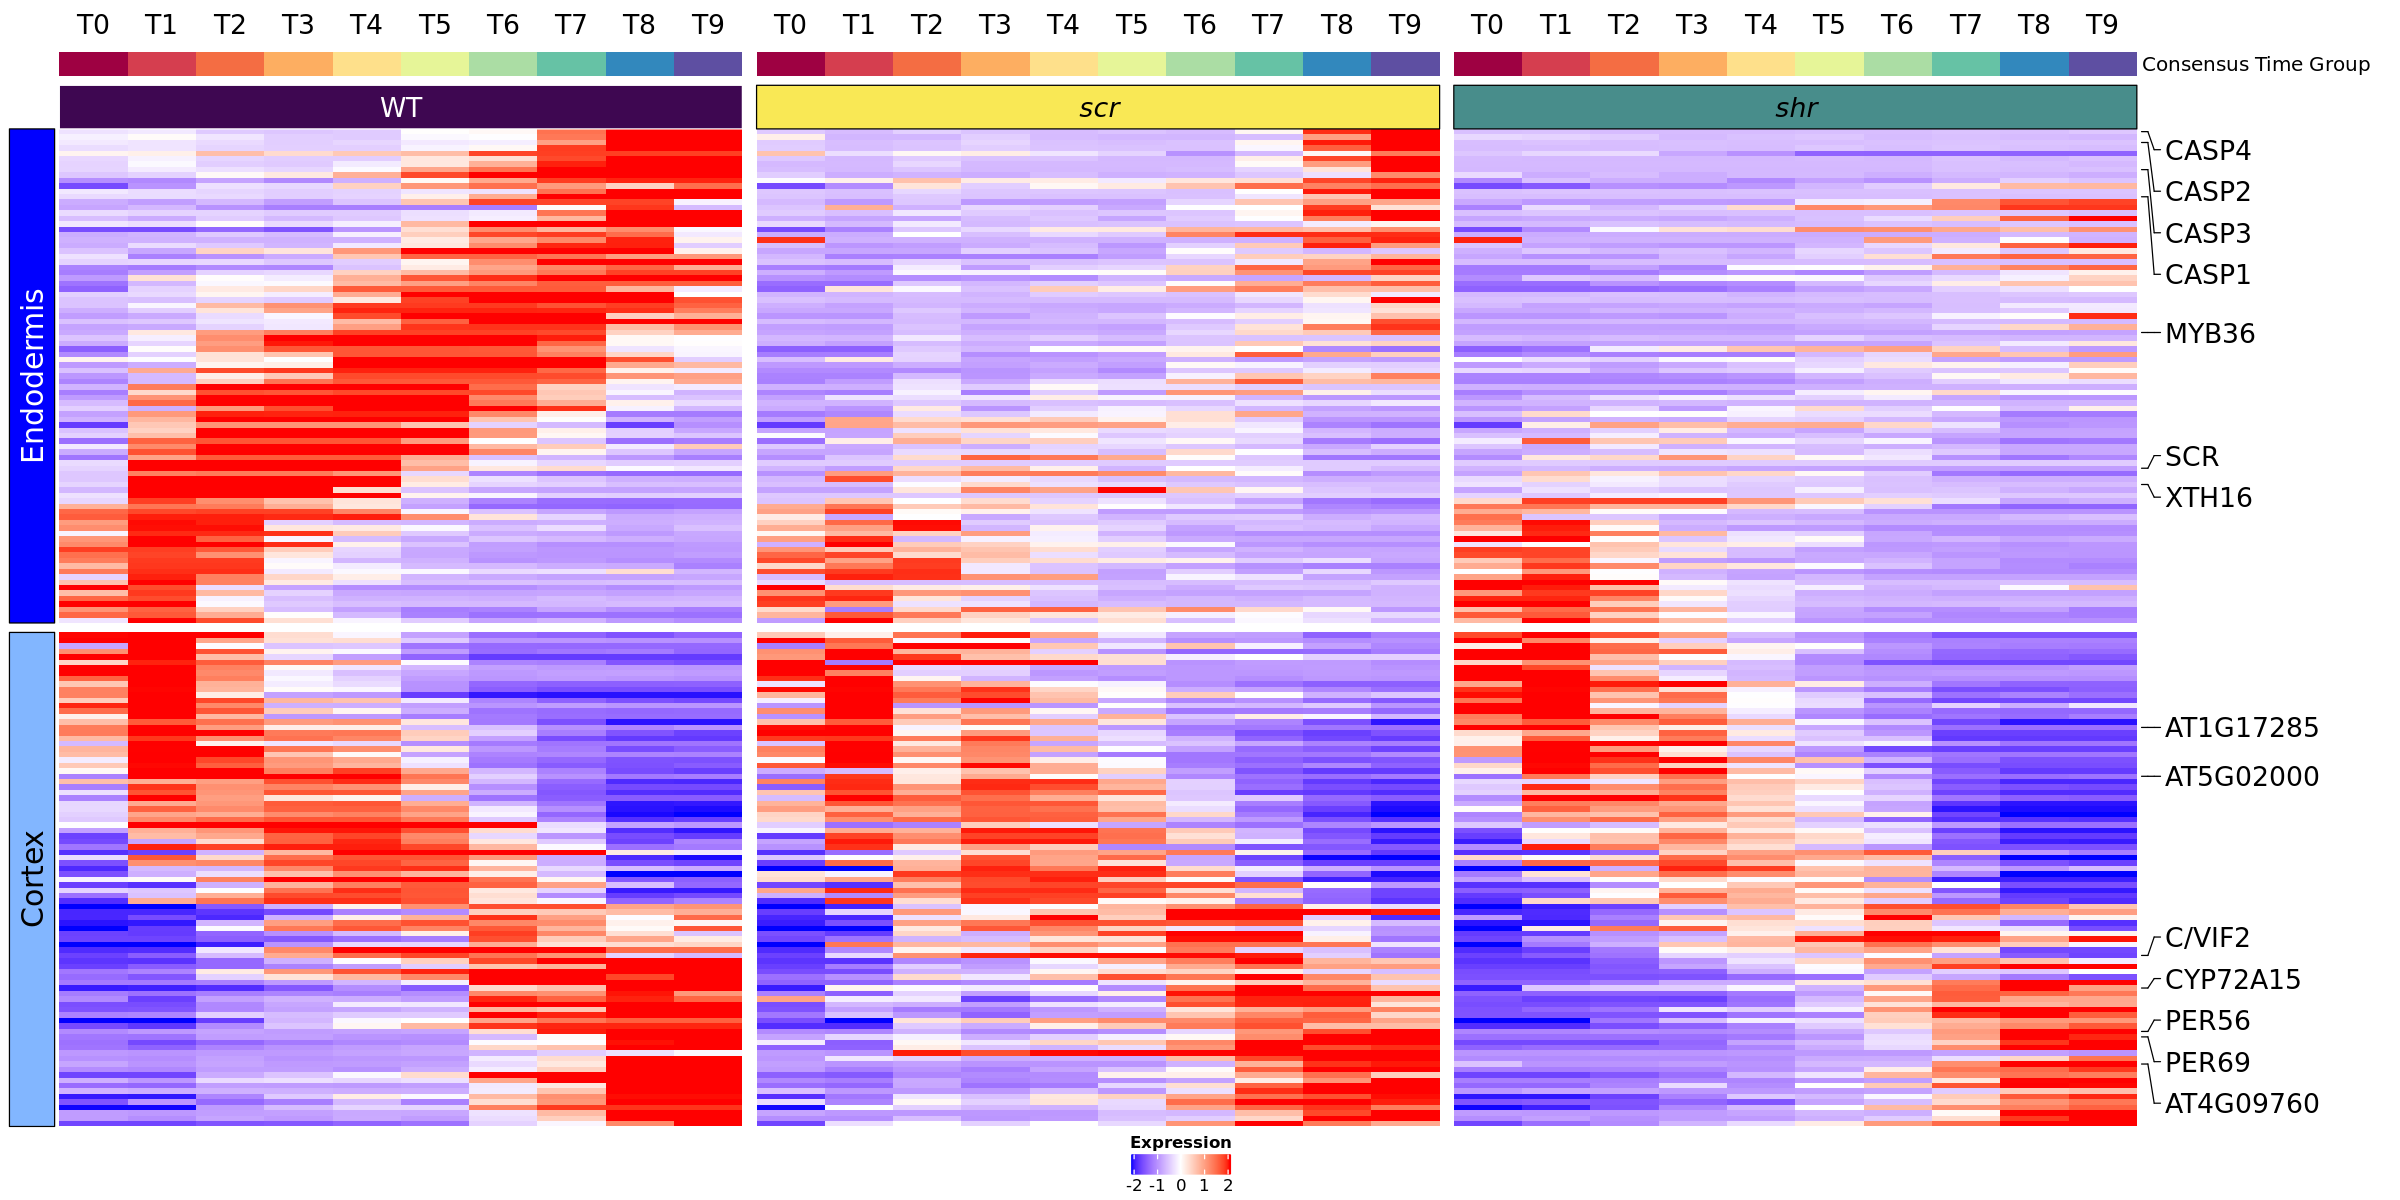

In [66]:
options(repr.plot.width=20, repr.plot.height=10)


ht_list = ht %v% ha %v% Endo_hm %v% Cortex_hm

draw(ht_list, ht_gap = unit(0.2, "cm"), padding = unit(c(2, 2, 5, 10), "mm"), heatmap_legend_side = "bottom")
# grab heatmap as a grob to arrange in cowplot
hm_final <- grid.grabExpr(draw(ht_list, ht_gap = unit(0.2, "cm"), padding = unit(c(2, 2, 5, 10), "mm"), heatmap_legend_side = "bottom"))## bottom, left, top and right



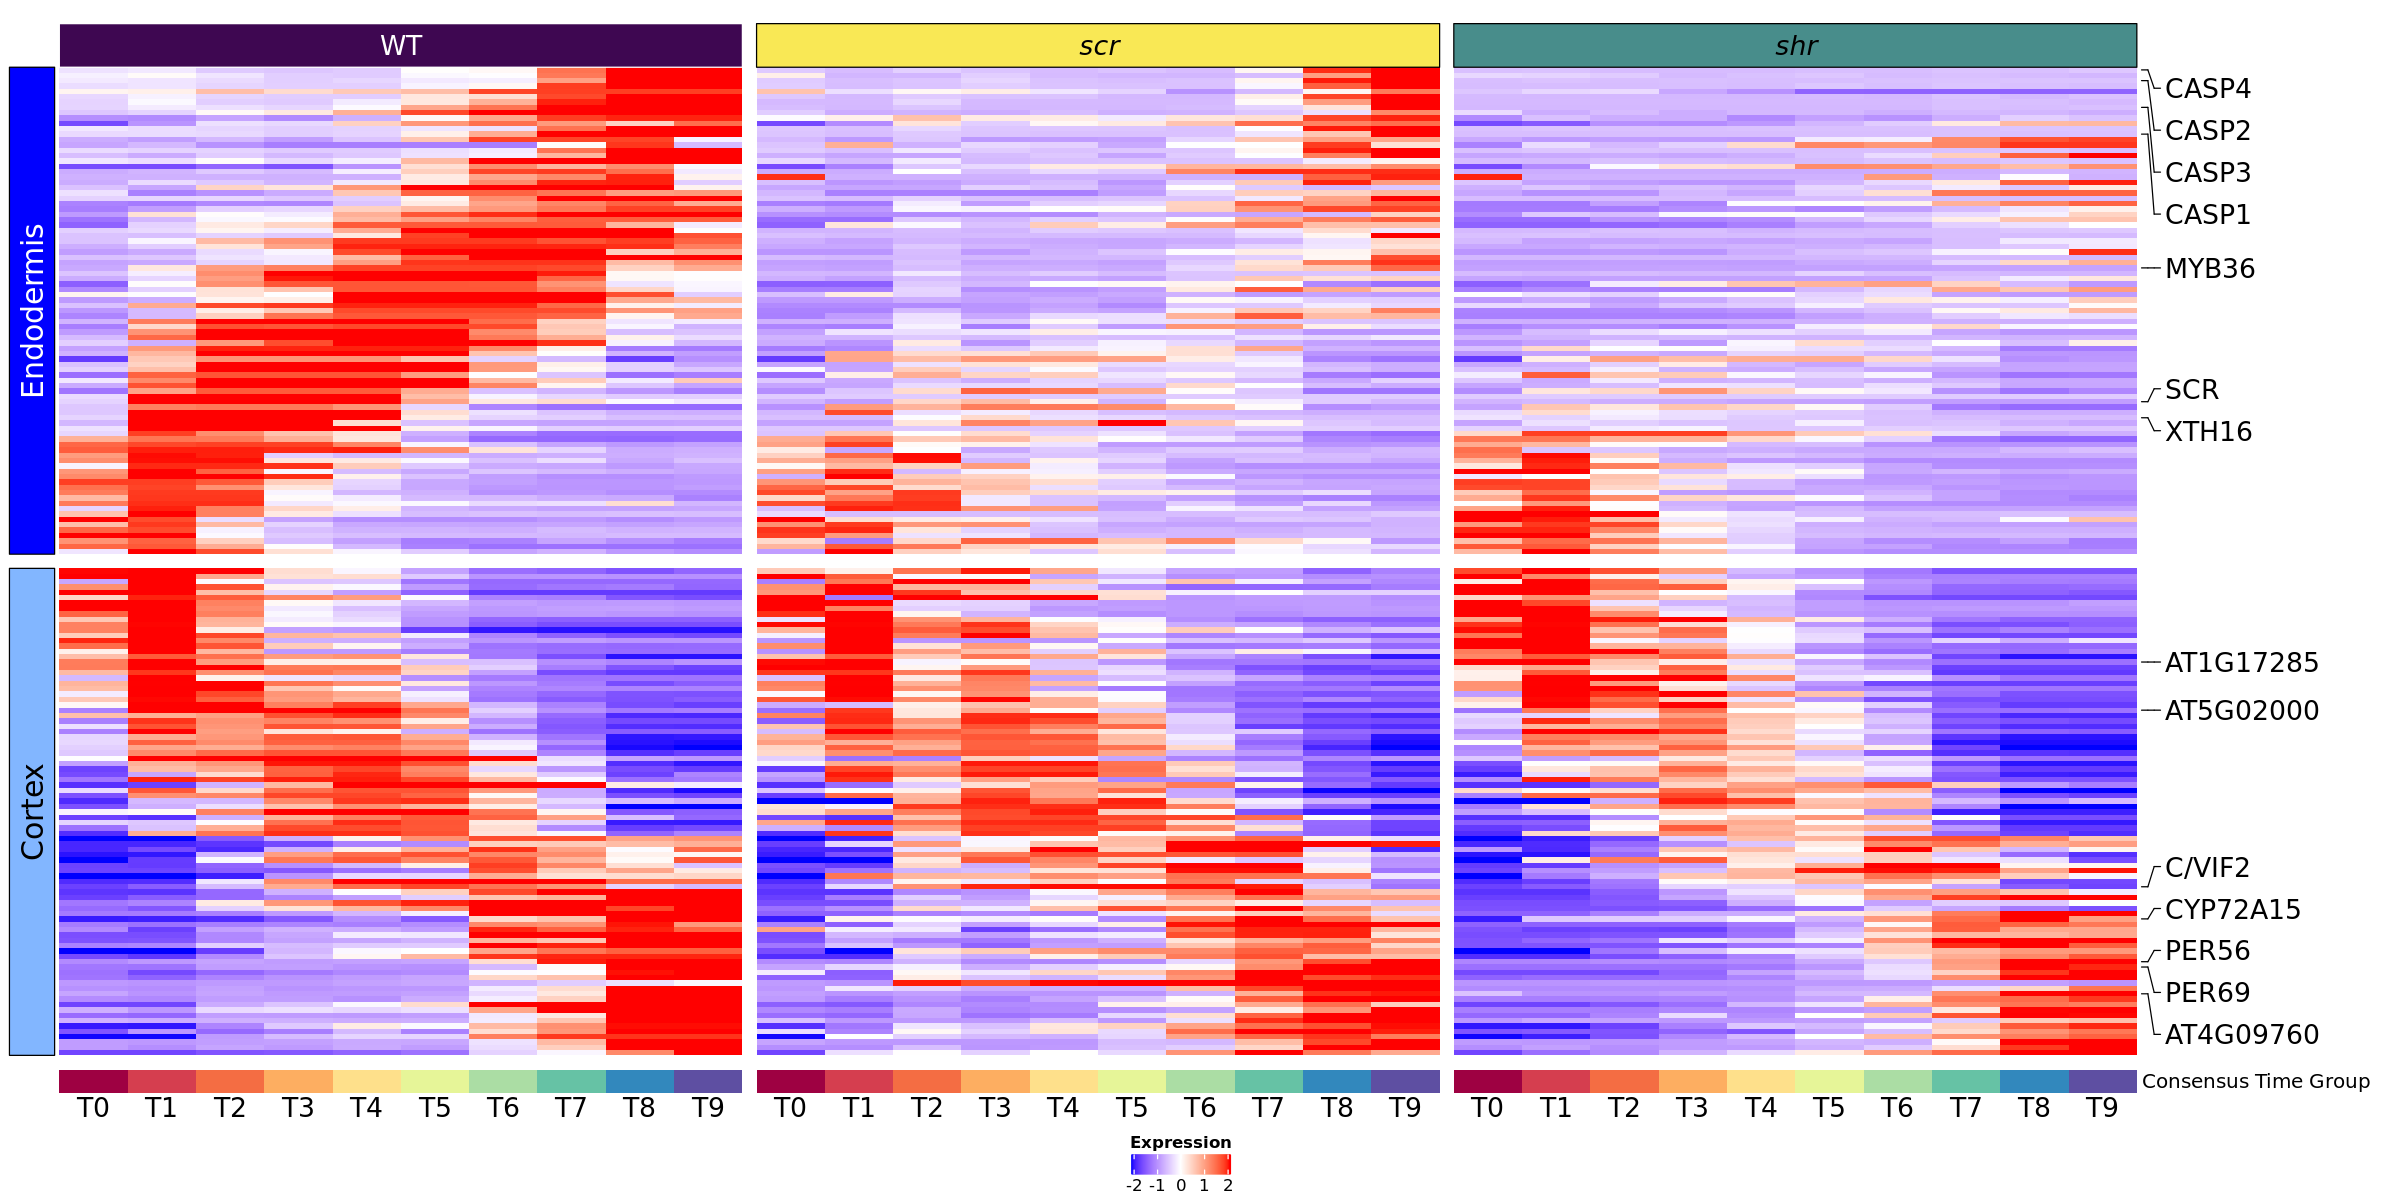

In [67]:
options(repr.plot.width=20, repr.plot.height=10)


ht_list =  Endo_hm %v% Cortex_hm  %v% ha %v% ht

draw(ht_list, ht_gap = unit(0.3, "cm"), padding = unit(c(2, 2, 5, 10), "mm"), heatmap_legend_side = "bottom")
# grab heatmap as a grob to arrange in cowplot
hm_final <- grid.grabExpr(draw(ht_list, ht_gap = unit(0.3, "cm"), padding = unit(c(2, 2, 5, 10), "mm"), heatmap_legend_side = "bottom"))## bottom, left, top and right



In [68]:
# output heatmap as pdf

pdf("./supp_data/WT_scr_shr_Ground_tissue_heatmap.pdf", width = 20, height = 10)
draw(ht_list, ht_gap = unit(0.3, "cm"), padding = unit(c(2, 2, 5, 10), "mm"), heatmap_legend_side = "bottom")
dev.off()

png 
  2

In [69]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/tmnolan7/anaconda3/envs/r_4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] RColorBrewer_1.1-2   future_1.17.0        ggrepel_0.8.2       
 [4] GeneOverlap_1.23.0   circlize_0.4.9       ComplexHeatmap_2.5.3
 [7] cowplot_1.0.0        Seurat_3.1.5         forcats_0.5.0       
[10] stringr_1.4.0        dplyr_1.0.0          purrr_0.3.4         
[13] readr_1.3.1